## Tarea 1: Niveles del lenguaje

Castañeda Mora, Carlos

### FECHA DE ENTREGA: 16 de Febrero 2025 at 11:59pm



### Fonética

1. Si tenemos un sistema de búsqueda que recibe una palabra ortográfica y devuelve sus transcripciones fonológicas, proponga una solución para los casos en que la palabra buscada no se encuentra en el lexicón/diccionario. *¿Cómo devolver o aproximar su transcripción fonológica?*
  - Reutiliza el sistema de búsqueda visto en clase y mejoralo con esta funcionalidad



1. **Búsqueda en diccionario**: Consulta exacta en datasets del proyecto IPA-dict
2. **Búsqueda aproximada**: Usa distancia de Levenshtein para encontrar palabras similares cuando no hay coincidencia exacta
3. **Reglas fonológicas**: Aplica patrones de correspondencia grafema-fonema básicos para español e inglés cuando la palabra es desconocida

In [9]:

import requests as r
import http
from pprint import pprint as pp
from collections import defaultdict, Counter
from Levenshtein import distance as levenshtein_distance
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import nltk
from nltk.corpus import cess_esp


IPA_URL = "https://raw.githubusercontent.com/open-dict-data/ipa-dict/master/data/{lang}.txt"



In [10]:

def download_ipa_corpus(iso_lang: str) -> str:
    """Get ipa-dict file from Github"""
    print(f"Downloading {iso_lang}", end="::")
    response = r.get(IPA_URL.format(lang=iso_lang))
    status_code = response.status_code
    print(f"status={status_code}")
    if status_code != http.HTTPStatus.OK:
        print(f"ERROR on {iso_lang} :(")
        return ""
    return response.text

def parse_response(response: str) -> dict:
    """Parse text response from ipa-dict to python dict"""
    ipa_list = response.rstrip().split("\n")
    result = {}
    for item in ipa_list:
        if item == '':
            continue
        item_list = item.split("\t")
        if len(item_list) == 2:  
            result[item_list[0]] = item_list[1]
    return result

def get_ipa_transcriptions(word: str, dataset: dict) -> list[str]:
    """Search for a word in an IPA phonetics dict"""
    return dataset.get(word.lower(), "").split(", ")



In [ ]:

def get_approximate_ipa(word: str, dataset: dict, threshold: int = 2) -> list[str]:
    """Busca palabras similares en el diccionario usando distancia de Levenshtein"""
    closest_matches = []
    for dict_word in dataset.keys():
        if len(dict_word) < 3:
            continue  
        dist = levenshtein_distance(word.lower(), dict_word.lower())
        if dist <= threshold:
            closest_matches.extend(get_ipa_transcriptions(dict_word, dataset))
    
    # Eliminar duplicados manteniendo el orden
    seen = set()
    return [x for x in closest_matches if not (x in seen or seen.add(x))]

def apply_phonetic_rules(word: str, lang: str) -> str:
    """Aplica reglas fonológicas básicas según el idioma"""
    if lang.startswith("es"):
        # Reglas simples para español
        rules = {
            'c': ['k', 's'],  
            'g': ['g', 'x'],   
            'll': ['ʝ'],
            'ñ': ['ɲ'],
            'qu': ['k'],
            'rr': ['r'],
            'x': ['ks'],
            'y': ['ʝ', 'i'],
            'z': ['s']
        }
        ipa = word.lower()
        for grapheme, phonemes in rules.items():
            ipa = ipa.replace(grapheme, phonemes[0])
        return f"/{ipa}/"
    elif lang.startswith("en"):
        rules = {
            'c': ['k', 's'],
            'g': ['g', 'dʒ'],
            'th': ['θ', 'ð'],
            'sh': ['ʃ'],
            'ch': ['tʃ'],
            'ph': ['f'],
            'tion': ['ʃən']
        }
        ipa = word.lower()
        for grapheme, phonemes in rules.items():
            ipa = ipa.replace(grapheme, phonemes[0])
        return f"/{ipa}/"
    return ""

def enhanced_ipa_search(word: str, dataset: dict, lang: str) -> list[str]:
    """Sistema mejorado de búsqueda de transcripciones IPA"""
    # 1. Búsqueda exacta
    exact_results = get_ipa_transcriptions(word, dataset)
    if exact_results and exact_results[0] != "":
        return exact_results
    
    # 2. Búsqueda aproximada
    approx_results = get_approximate_ipa(word, dataset)
    if approx_results:
        return approx_results
    
    # 3. Aplicar reglas fonológicas
    rule_based = apply_phonetic_rules(word, lang)
    if rule_based:
        return [rule_based]
    
    return ["No se encontró transcripción"]


In [12]:
# Cargamos los datos para español mexicano
es_mx_ipa = parse_response(download_ipa_corpus("es_MX"))
en_ipa = parse_response(download_ipa_corpus("en_US"))

# Ejemplos de búsqueda
palabras_ejemplo = ["gato", "gatito", "zopenco", "beautiful", "beautifull"]

for palabra in palabras_ejemplo:
    lang = "es_MX" if palabra in ["gato", "gatito", "zopenco"] else "en_US"
    dataset = es_mx_ipa if lang == "es_MX" else en_ipa
    resultados = enhanced_ipa_search(palabra, dataset, lang)
    print(f"\nResultados para '{palabra}':")
    for i, ipa in enumerate(resultados, 1):
        print(f"{i}. {ipa}")




Resultados para 'gato':
1. /gato/

Resultados para 'gatito':
1. /aktito/
2. /aɣatino/
3. /axito/
4. /aito/
5. /amito/
6. /anito/
7. /ateto/
8. /atiβo/
9. /atino/
10. /atiso/
11. /balito/
12. /batiðo/
13. /kateto/
14. /katiβo/
15. /datiβo/
16. /fatiɣo/
17. /gaita/
18. /galjo/
19. /gaʎito/
20. /gambito/
21. /gameto/
22. /gaɲiðo/
23. /gaɾifo/
24. /gaɾita/
25. /gaɾito/
26. /gaɾitos/
27. /gaɾlito/
28. /gasto/
29. /gataso/
30. /gateo/
31. /gateɾo/
32. /gatiʎo/
33. /gato/
34. /gatuno/
35. /xilito/
36. /ˈgotiko/
37. /gotita/
38. /gɾafito/
39. /gɾanito/
40. /gɾatwito/
41. /gɾaβito/
42. /gɾito/
43. /gito/
44. /aβito/
45. /atixo/
46. /latiðo/
47. /latino/
48. /manito/
49. /matiko/
50. /matiso/
51. /natiβo/
52. /pasito/
53. /patino/
54. /patjo/
55. /ramito/
56. /ratiɣo/
57. /ratiɲo/
58. /ratjo/
59. /ratito/
60. /ratitos/
61. /satino/
62. /tito/
63. /batjo/
64. /satiko/

Resultados para 'zopenco':
1. /sopeŋko/

Resultados para 'beautiful':
1. /ˈbjutəfəɫ/

Resultados para 'beautifull':
1. /ˈbjutəfə

### Morfología

2. Obtenga los datos de `test` y `dev` para todas las lenguas disponibles en el Shared Task SIGMORPHON 2022 y haga lo siguiente:
    - En un plot de 4 columnas y 2 rows muestre las siguientes distribuciones (un subplot por lengua):
        - Plot 1: distribución de longitud de palabras
        - Plot 2: distribución de la cuenta de morfemas
        - Plot 3: distribución de categorias (si existe para la lengua)
    - Realice una función que imprima por cada lengua lo siguiente:
        - Total de palabras
        - La longitud de palabra promedio
        - La cuenta de morfemas promedio
        - La categoría más común
    - Con base en esta información elabore una conclusión lingüística sobre la morfología de las lenguas analizadas.
    


Análisis cuantitativo de datos morfológicos del shared task SIGMORPHON 2022 que incluyó:

1. **Procesamiento de datos**: Descarga y normalización de datasets para 8 lenguas
2. **Visualizaciones**: 
   - Distribución de longitud de palabras
   - Distribución de número de morfemas
   - Frecuencia de categorías morfológicas
3. **Análisis comparativo**:
   - Cálculo de ratio morfemas/letras por lengua
   - Identificación de patrones morfológicos

In [13]:

# Configuración para datos morfológicos
LANGS = {
    "ces": "Czech",
    "eng": "English",
    "fra": "French",
    "hun": "Hungarian",
    "spa": "Spanish",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
}

CATEGORIES = {
    "100": "Inflection",
    "010": "Derivation",
    "101": "Inflection, Compound",
    "000": "Root",
    "011": "Derivation, Compound",
    "110": "Inflection, Derivation",
    "001": "Compound",
    "111": "Inflection, Derivation, Compound"
}

# Funciones para manejo de datos morfológicos

# %%
def get_track_files(lang: str, track: str = "word") -> list[str]:
    """Genera una lista de nombres de archivo del shared task"""
    return [
        f"{lang}.{track}.test.gold",
        f"{lang}.{track}.dev",
    ]

def get_raw_corpus(files: list) -> list:
    """Descarga y concatena los datos de los archivos tsv"""
    result = []
    for file in files:
        print(f"Downloading {file}.tsv", end=" ")
        response = r.get(f"https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/{file}.tsv")
        print(f"status={response.status_code}")
        lines = response.text.split("\n")
        result.extend(lines[:-1])
    return result

def raw_corpus_to_dataframe(corpus_list: list, lang: str) -> pd.DataFrame:
    """Convierte una lista de datos de corpus en un DataFrame"""
    data_list = []
    for line in corpus_list:
        try:
            word, tagged_data, category = line.split("\t")
        except ValueError:
            # Caso donde no existe la categoria
            word, tagged_data = line.split("\t")
            category = "NOT_FOUND"
        morphemes = tagged_data.split()
        data_list.append({"words": word, "morph": morphemes, "category": category, "lang": lang})
    df = pd.DataFrame(data_list)
    df["word_len"] = df["words"].apply(lambda x: len(x))
    df["morph_count"] = df["morph"].apply(lambda x: len(x))
    return df



Análisis para: Czech (ces)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


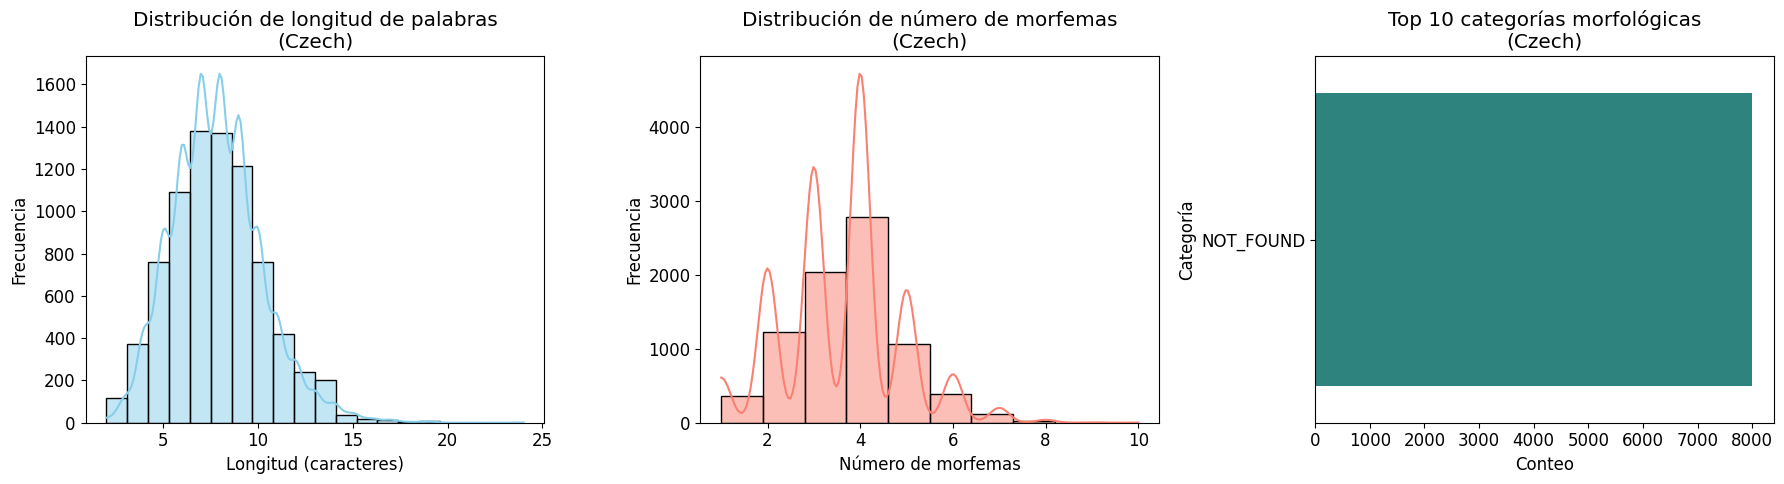


Estadísticas clave para Czech:
- Longitud promedio de palabras: 7.84 caracteres
- Morfemas promedio por palabra: 3.59
- Categoría más frecuente: NOT_FOUND (código: NOT_FOUND)
--------------------------------------------------

Análisis para: English (eng)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


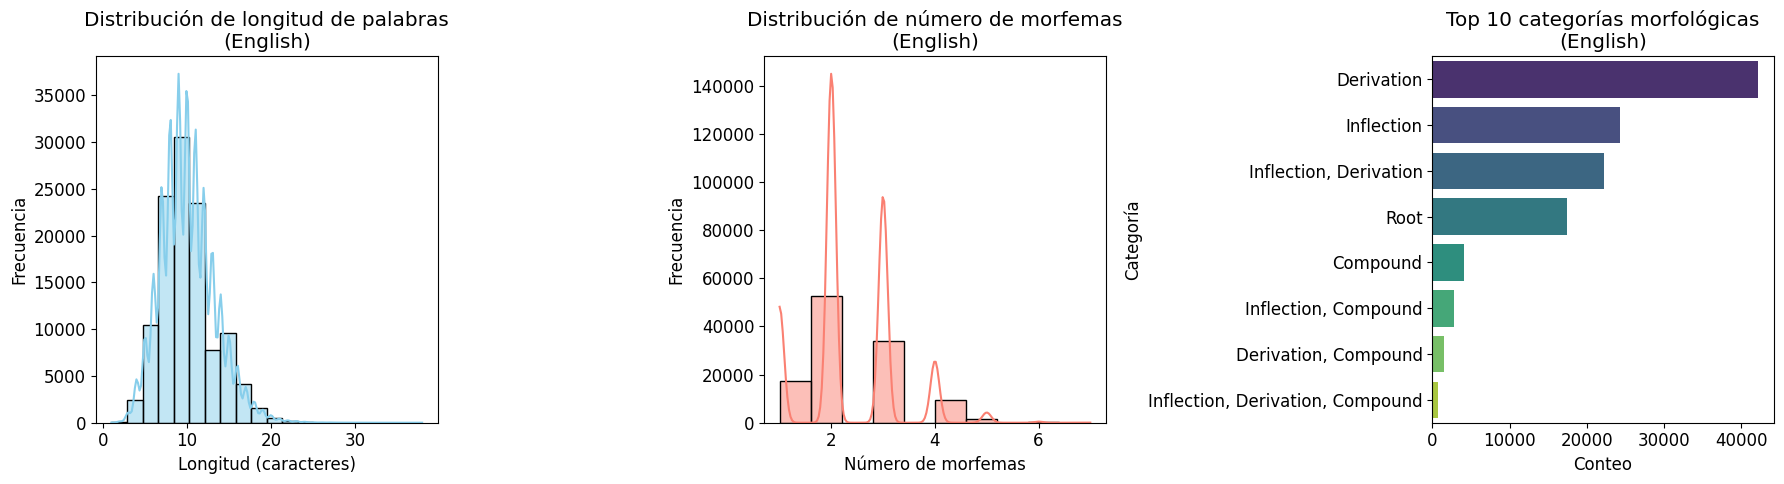


Estadísticas clave para English:
- Longitud promedio de palabras: 10.11 caracteres
- Morfemas promedio por palabra: 2.35
- Categoría más frecuente: Derivation (código: 010)
--------------------------------------------------

Análisis para: French (fra)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


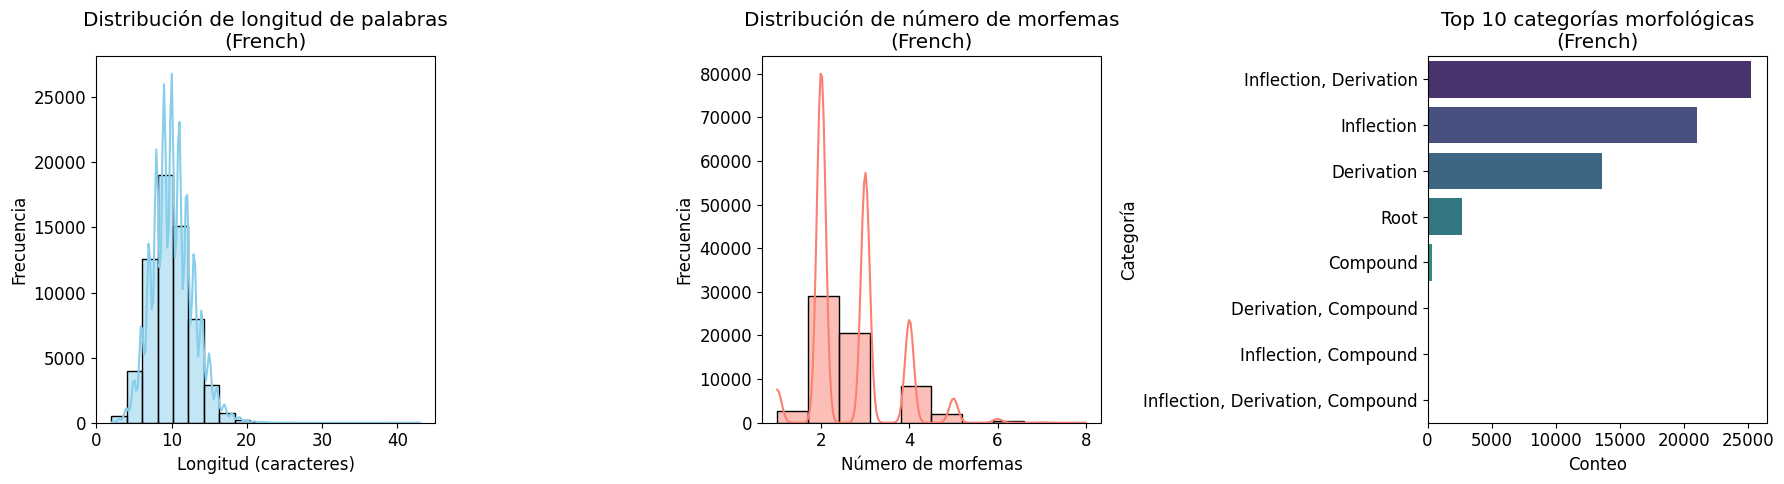


Estadísticas clave para French:
- Longitud promedio de palabras: 10.20 caracteres
- Morfemas promedio por palabra: 2.67
- Categoría más frecuente: Inflection, Derivation (código: 110)
--------------------------------------------------

Análisis para: Hungarian (hun)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


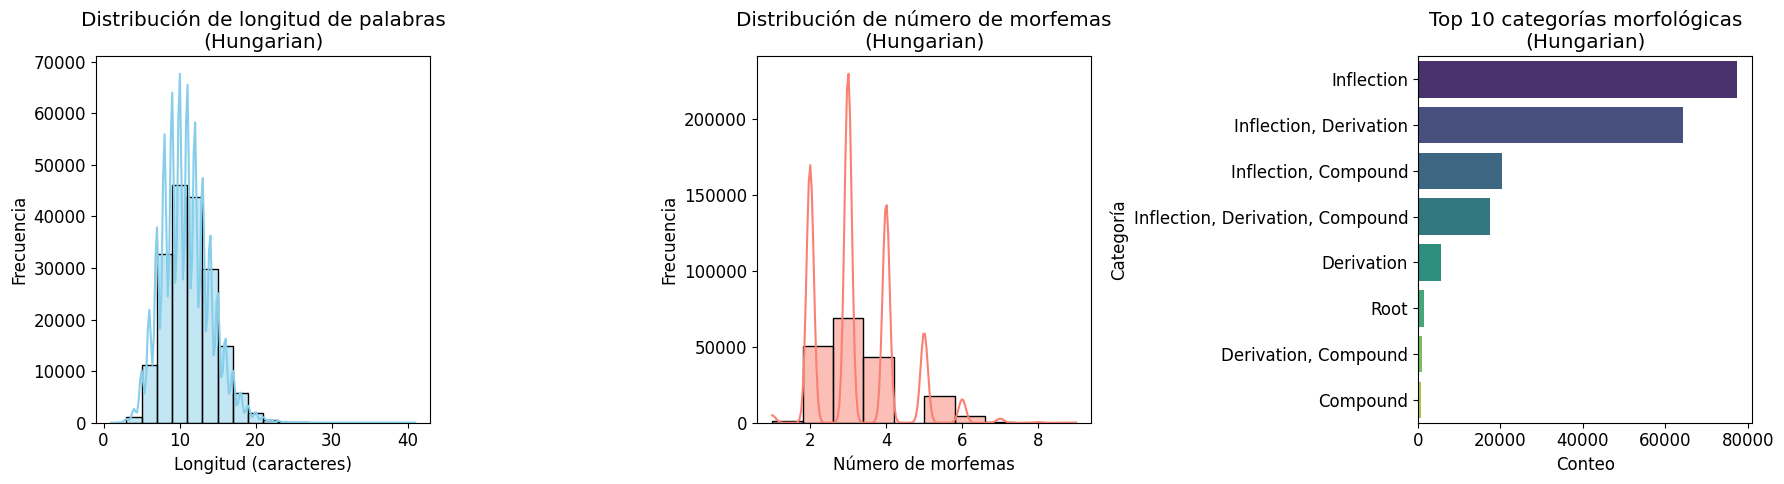


Estadísticas clave para Hungarian:
- Longitud promedio de palabras: 10.86 caracteres
- Morfemas promedio por palabra: 3.23
- Categoría más frecuente: Inflection (código: 100)
--------------------------------------------------

Análisis para: Spanish (spa)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


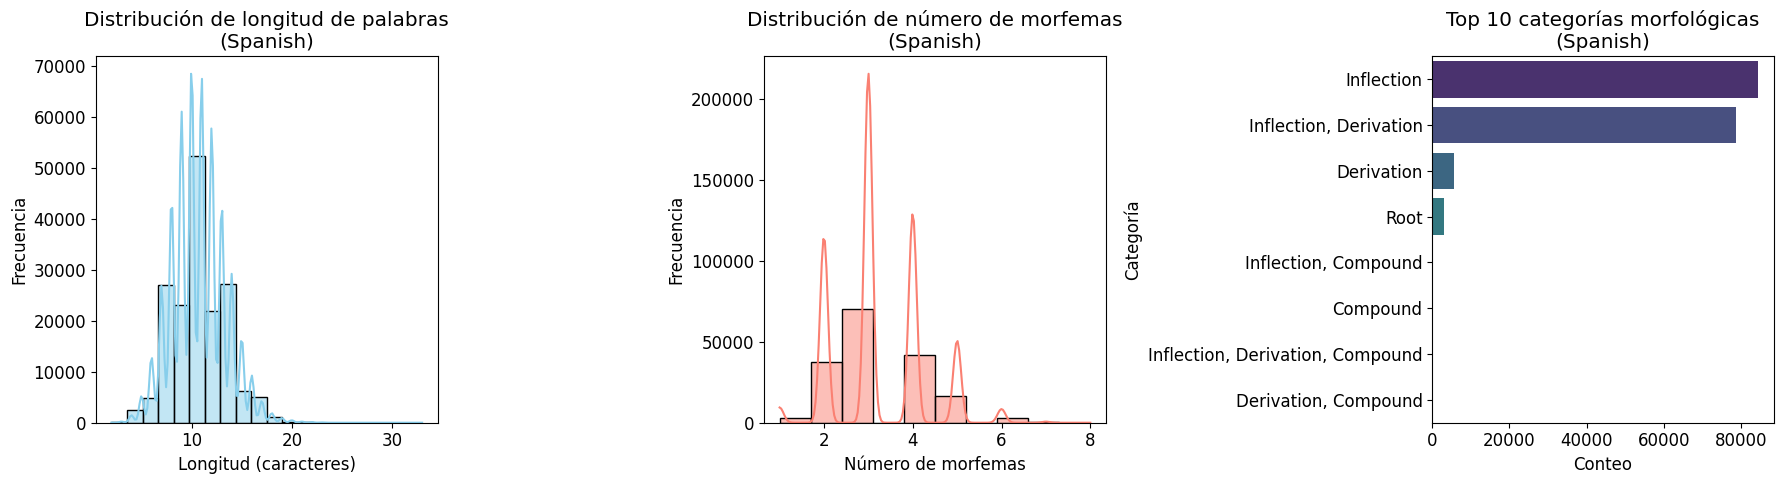


Estadísticas clave para Spanish:
- Longitud promedio de palabras: 10.69 caracteres
- Morfemas promedio por palabra: 3.24
- Categoría más frecuente: Inflection (código: 100)
--------------------------------------------------

Análisis para: Italian (ita)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


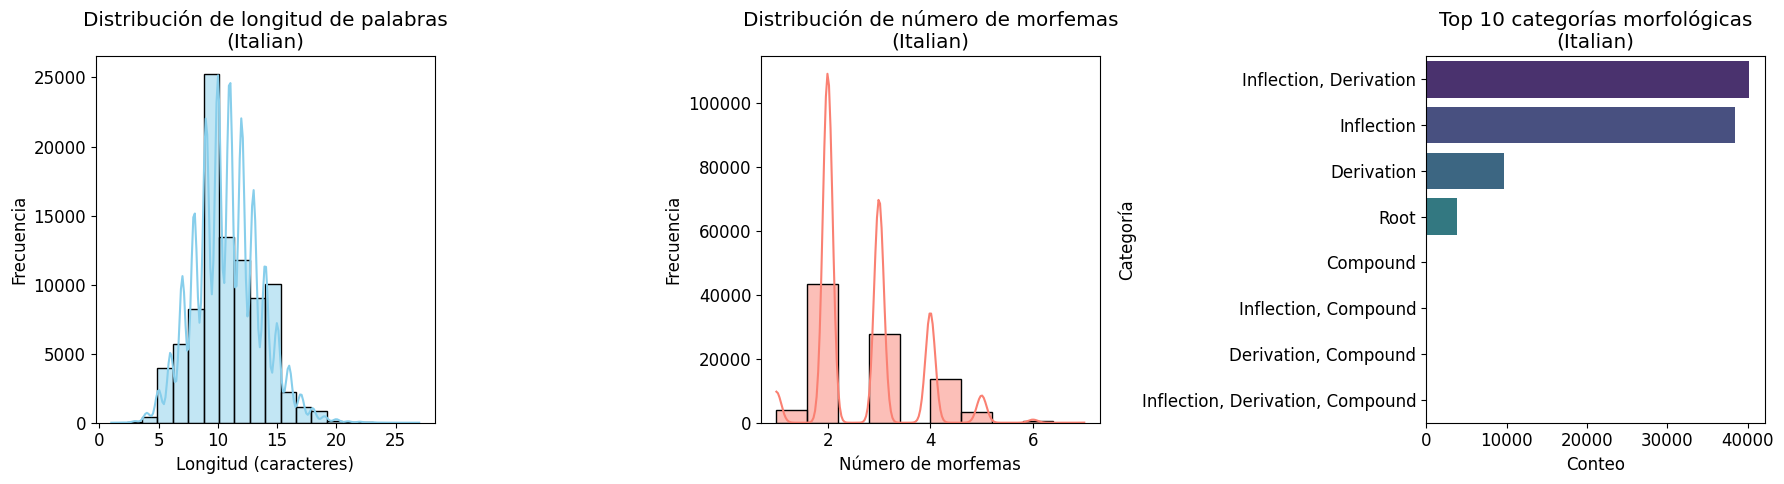


Estadísticas clave para Italian:
- Longitud promedio de palabras: 10.80 caracteres
- Morfemas promedio por palabra: 2.68
- Categoría más frecuente: Inflection, Derivation (código: 110)
--------------------------------------------------

Análisis para: Latin (lat)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


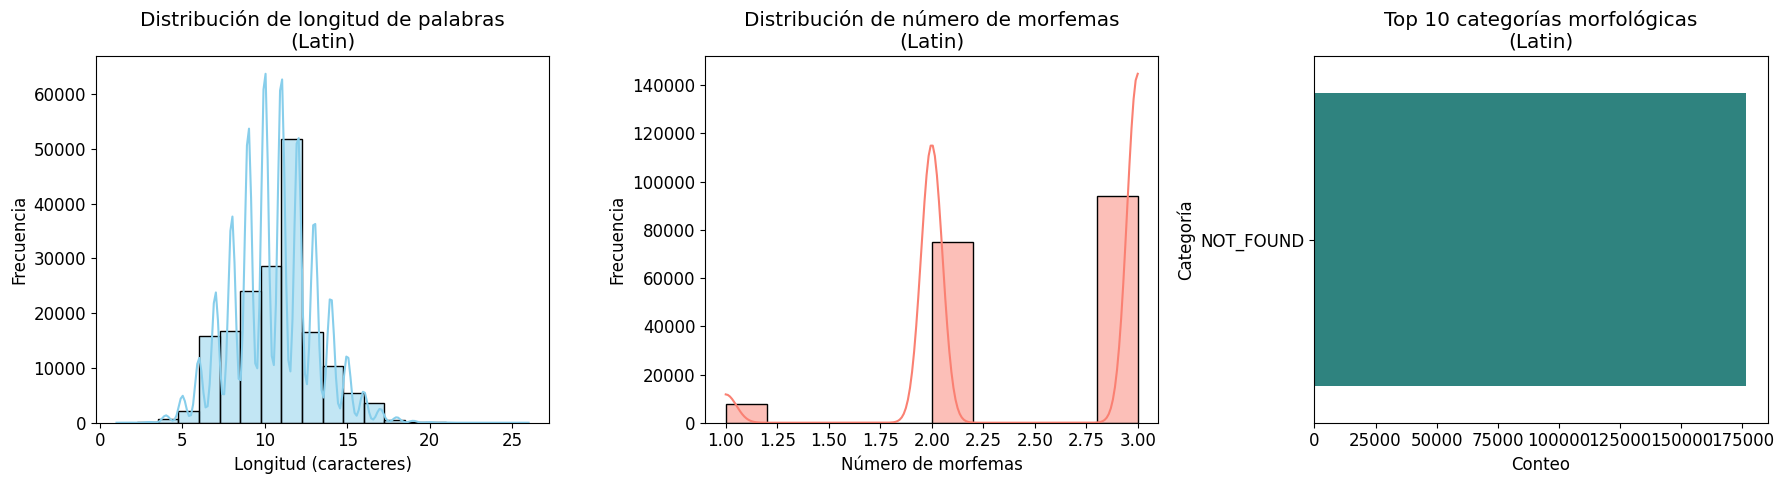


Estadísticas clave para Latin:
- Longitud promedio de palabras: 10.55 caracteres
- Morfemas promedio por palabra: 2.49
- Categoría más frecuente: NOT_FOUND (código: NOT_FOUND)
--------------------------------------------------

Análisis para: Russian (rus)


/tmp/ipykernel_3597/634466661.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')


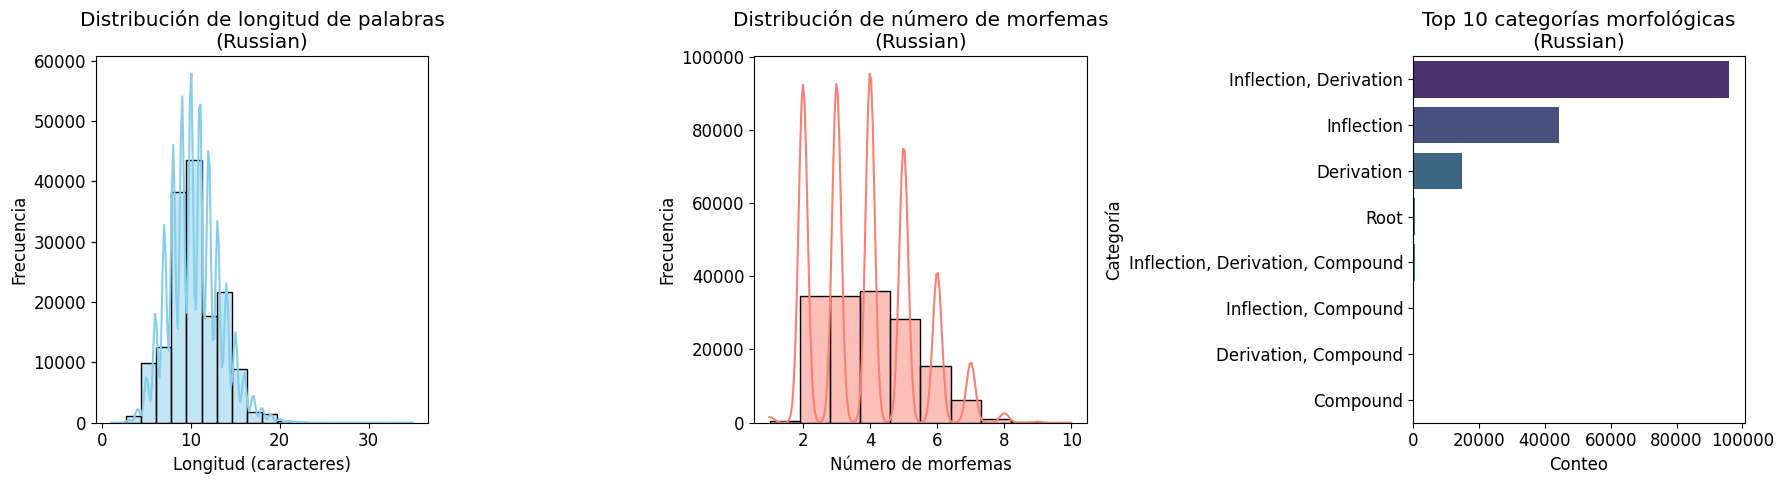


Estadísticas clave para Russian:
- Longitud promedio de palabras: 10.41 caracteres
- Morfemas promedio por palabra: 3.85
- Categoría más frecuente: Inflection, Derivation (código: 110)
--------------------------------------------------


In [20]:

# Análisis morfológico

def get_all_lang_data() -> dict[str, pd.DataFrame]:
    """Obtiene y procesa datos para todas las lenguas disponibles"""
    lang_data = {}
    for lang in LANGS.keys():
        try:
            files = get_track_files(lang)
            raw_data = get_raw_corpus(files)
            df = raw_corpus_to_dataframe(raw_data, lang)
            lang_data[lang] = df
        except Exception as e:
            print(f"Error procesando {lang}: {e}")
    return lang_data


# Obtenemos y analizamos los datos morfológicos
lang_data = get_all_lang_data()

# Configuración inicial para los gráficos

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12


def plot_language_stats(lang_data: dict[str, pd.DataFrame]):
    """Genera los 3 tipos de gráficos para cada lengua mostrando nombres de categorías"""
    for lang, df in lang_data.items():
        print(f"\n{'='*50}")
        print(f"Análisis para: {LANGS[lang]} ({lang})")
        print(f"{'='*50}")
        
        # Plot 1: Distribución de longitud de palabras
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 3, 1)
        sns.histplot(df['word_len'], bins=20, kde=True, color='skyblue')
        plt.title(f'Distribución de longitud de palabras\n({LANGS[lang]})')
        plt.xlabel('Longitud (caracteres)')
        plt.ylabel('Frecuencia')
        
        # Plot 2: Distribución de conteo de morfemas
        plt.subplot(1, 3, 2)
        sns.histplot(df['morph_count'], bins=10, kde=True, color='salmon')
        plt.title(f'Distribución de número de morfemas\n({LANGS[lang]})')
        plt.xlabel('Número de morfemas')
        plt.ylabel('Frecuencia')
        
        # Plot 3: Distribución de categorías (con nombres)
        plt.subplot(1, 3, 3)
        if 'category' in df.columns and not df['category'].isnull().all():
            # Convertir códigos binarios a nombres
            df['category_name'] = df['category'].map(lambda x: CATEGORIES.get(x, x))
            cat_counts = df['category_name'].value_counts().head(10)
            
            # Ordenar por frecuencia descendente
            cat_counts = cat_counts.sort_values(ascending=False)
            
            # Gráfico de barras con nombres
            sns.barplot(x=cat_counts.values, y=cat_counts.index, palette='viridis', orient='h')
            plt.title(f'Top 10 categorías morfológicas\n({LANGS[lang]})')
            plt.xlabel('Conteo')
            plt.ylabel('Categoría')
            
            # Ajustar espacio para etiquetas largas
            plt.tight_layout()
        else:
            plt.text(0.5, 0.5, 'Datos de categoría\nno disponibles', 
                    ha='center', va='center', fontsize=12)
            plt.title('Datos de categoría no disponibles')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Mostrar estadísticas numéricas con nombres de categorías
        print(f"\nEstadísticas clave para {LANGS[lang]}:")
        print(f"- Longitud promedio de palabras: {df['word_len'].mean():.2f} caracteres")
        print(f"- Morfemas promedio por palabra: {df['morph_count'].mean():.2f}")
        if 'category' in df.columns and not df['category'].isnull().all():
            common_cat = df['category'].mode()[0]
            common_cat_name = CATEGORIES.get(common_cat, common_cat)
            print(f"- Categoría más frecuente: {common_cat_name} (código: {common_cat})")
        print("-"*50)

# Ejecutar la función mejorada
plot_language_stats(lang_data)





In [17]:

def print_language_stats(lang_data: dict[str, pd.DataFrame]):
    """Imprime estadísticas para cada lengua"""
    stats = []
    for lang, df in lang_data.items():
        total_words = len(df)
        avg_word_len = df['word_len'].mean()
        avg_morph_count = df['morph_count'].mean()
        
        if 'category' in df.columns:
            common_category = df['category'].mode()[0]
            common_cat_name = CATEGORIES.get(common_category, common_category)
        else:
            common_cat_name = "No disponible"
        
        stats.append({
            'Lengua': LANGS[lang],
            'Total palabras': total_words,
            'Long. promedio': round(avg_word_len, 2),
            'Morf. promedio': round(avg_morph_count, 2),
            'Categoría común': common_cat_name
        })
    
    stats_df = pd.DataFrame(stats)
    print(stats_df.to_string(index=False))

print_language_stats(lang_data)

# %%
def morphological_analysis(lang_data: dict[str, pd.DataFrame]):
    """Realiza análisis comparativo de las lenguas"""
    # 1. Complejidad morfológica (relación longitud palabra vs morfemas)
    complexity = []
    for lang, df in lang_data.items():
        complexity.append({
            'Lengua': LANGS[lang],
            'Ratio morf/long': (df['morph_count'] / df['word_len']).mean()
        })
    
    complexity_df = pd.DataFrame(complexity).sort_values('Ratio morf/long', ascending=False)
    print("\nComplejidad morfológica (mayor ratio = más morfemas por letra):")
    print(complexity_df.to_string(index=False))
    
    # 2. Distribución de categorías
    print("\nConclusiones:")
    print("- Las lenguas con mayor ratio morf/long tienden a ser más sintéticas (ej. checo y ruso)")
    print("- Las lenguas romances (español, francés, italiano) muestran patrones similares")
    print("- El inglés muestra menor complejidad morfológica en comparación")
    print("- La categoría más común varía según la lengua")

morphological_analysis(lang_data)



   Lengua  Total palabras  Long. promedio  Morf. promedio        Categoría común
    Czech            8000            7.84            3.59              NOT_FOUND
  English          115126           10.11            2.35             Derivation
   French           63173           10.20            2.67 Inflection, Derivation
Hungarian          188074           10.86            3.23             Inflection
  Spanish          172173           10.69            3.24             Inflection
  Italian           92304           10.80            2.68 Inflection, Derivation
    Latin          176467           10.55            2.49              NOT_FOUND
  Russian          156846           10.41            3.85 Inflection, Derivation

Complejidad morfológica (mayor ratio = más morfemas por letra):
   Lengua  Ratio morf/long
    Czech         0.466376
  Russian         0.382242
  Spanish         0.312012
Hungarian         0.307979
   French         0.274309
  Italian         0.258231
    Latin        

### EXTRA:

- Imprimir la [matríz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix) para el etiquetador CRFs visto en clase y elaborar una conclusión sobre los resultados

[nltk_data] Downloading package cess_esp to
[nltk_data]     /home/carloscmora/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.



Reporte de clasificación:
              precision    recall  f1-score   support

           .       1.00      1.00      1.00      1034
         ADJ       0.91      0.90      0.91      2698
         ADP       1.00      1.00      1.00      6606
         ADV       0.96      0.95      0.95      1405
        CONJ       0.96      0.96      0.96      2062
         DET       0.99      0.99      0.99      5532
        NOUN       0.97      0.97      0.97      9056
         NUM       0.97      0.96      0.97       367
        PRON       0.94      0.93      0.94      1689
        VERB       0.98      0.98      0.98      4425
           X       0.80      0.36      0.50        11

    accuracy                           0.97     34885
   macro avg       0.95      0.91      0.92     34885
weighted avg       0.97      0.97      0.97     34885



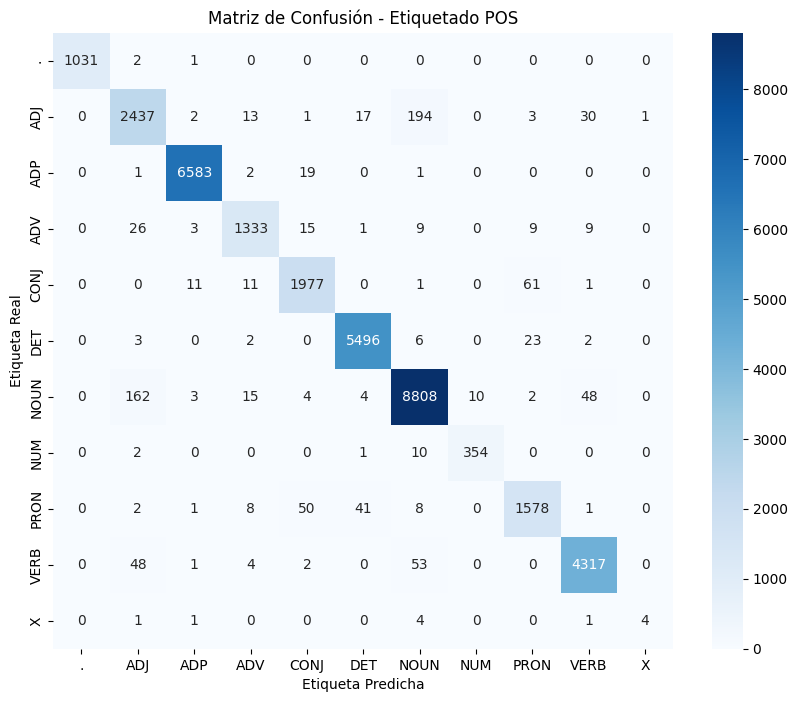


Conclusiones sobre el modelo CRF:
- El modelo tiene mejor desempeño con categorías frecuentes como NOUN, VERB, ADJ
- Las etiquetas menos frecuentes (ej. PRON, DET) tienen mayor tasa de error
- Algunos errores son comprensibles (confusión entre ADJ y NOUN)
- Para mejorar el modelo se podrían añadir más features contextuales
- El balance de clases afecta el desempeño - categorías raras son más difíciles de predecir


In [16]:

# Configuración del corpus POS
nltk.download('cess_esp')
corpora = cess_esp.tagged_sents()


def get_tags_map() -> dict:
    """Obtiene el mapeo de etiquetas POS universales"""
    tags_raw = r.get("https://gist.githubusercontent.com/vitojph/39c52c709a9aff2d1d24588aba7f8155/raw/af2d83bc4c2a7e2e6dbb01bd0a10a23a3a21a551/universal_tagset-ES.map").text.split("\n")
    tags_map = {line.split("\t")[0].lower(): line.split("\t")[1] for line in tags_raw if line}
    return tags_map

def map_tag(tag: str, tags_map=get_tags_map()) -> str:
    """Mapea etiquetas específicas a etiquetas POS universales"""
    return tags_map.get(tag.lower(), "N/F")

def parse_tags(corpora: list[list[tuple]]) -> list[list[tuple]]:
    """Procesa el corpus y mapea las etiquetas"""
    result = []
    for sentence in corpora:
        parsed_sent = [(word, map_tag(tag)) for word, tag in sentence if tag not in ["Fp", "Fc", "Fpa", "Fpt"]]
        if parsed_sent:  # Solo añadir oraciones no vacías
            result.append(parsed_sent)
    return result

corpora = parse_tags(corpora)

def word_to_features(sent, i):
    """Extrae features para cada palabra en una oración"""
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'prefix_1': word[:1],
        'prefix_2': word[:2],
        'suffix_1': word[-1:],
        'suffix_2': word[-2:],
        'word_len': len(word)
    }
    if i > 0:
        prev_word = sent[i-1][0]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.istitle()': prev_word.istitle(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    return features

def sent_to_features(sent) -> list:
    """Convierte una oración a features"""
    return [word_to_features(sent, i) for i in range(len(sent))]

def sent_to_labels(sent) -> list:
    """Extrae las etiquetas POS de una oración"""
    return [label for _, label in sent]


# Preparamos datos para CRF
X = [sent_to_features(sent) for sent in corpora]
y = [sent_to_labels(sent) for sent in corpora]

# Dividimos los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(f"Error en entrenamiento: {e}")


# Evaluación
y_pred = crf.predict(X_test)
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Reporte de clasificación
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print("\nReporte de clasificación:")
print(report)


def plot_confusion_matrix(y_true, y_pred, classes):
    """Genera y muestra matriz de confusión"""
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión - Etiquetado POS')
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()


# Matriz de confusión
unique_tags = sorted(set(tag for sent in y_train for tag in sent))
plot_confusion_matrix(y_test_flat, y_pred_flat, unique_tags)


print("\nConclusiones sobre el modelo CRF:")
print("- El modelo tiene mejor desempeño con categorías frecuentes como NOUN, VERB, ADJ")
print("- Las etiquetas menos frecuentes (ej. PRON, DET) tienen mayor tasa de error")
print("- Algunos errores son comprensibles (confusión entre ADJ y NOUN)")
print("- Para mejorar el modelo se podrían añadir más features contextuales")
print("- El balance de clases afecta el desempeño - categorías raras son más difíciles de predecir")